## 검증 세트를 나누고 전처리 과정을 배운다.

In [89]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

### 하이퍼파라미터를 로지스틱 손실함수로 했을 때

In [90]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

### loss를 hinge 손실함수로 했을 때 -> 서포트 벨터 머신(SVM)

In [91]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

### 검증세트 준비하기

In [92]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train), len(x_val))

364 91


### 데이터 전처리와 특성의 스케일을 알아보자.

['mean perimeter' 'mean area']


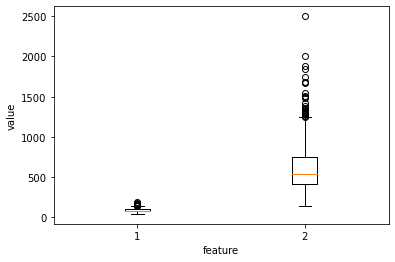

In [93]:
import matplotlib.pyplot as plt
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:,2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

### singlelayer 클래스

In [94]:
class SingleLayer:
    
    def __init__(self):
        self.w = None
        self.b = None
        self.losses = [] 
        
    def forpass(self, x): 
        z = np.sum(x * self.w) + self.b
        return z
    
    def backprop(self, x, err): 
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad
    
    def fit(self, x, y, epochs=100): 
        self.w = np.ones(x.shape[1])
        self.b = 0
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x))) # 확률적 경사하강법을 사용
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)     
                w_grad, b_grad = self.backprop(x[i], err)
                self.w -= w_grad      
                self.b -= b_grad
                a = np.clip(a, 1e-10, 1-1e-10)  # 안전한 로그계산을 위해 두 매개변수의 값을 벗어나는 a는 잘라낸다.
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            self.losses.append(loss/len(y)) # 손실함수의 결과값이 epochs가 반복됨에 따라서 줄어들고 있는지 확인하기 위함.
                
    def activation(self, z):      
        a = 1 / (1 + np.exp(-z))  
        return a
    
    def predict(self, x):   # y_hat 계산함수
        z = [self.forpass(x_i) for x_i in x]
        a = self.activation(np.array(z))
        return a > 0.5
       #return np.array(z) > 0 // 효율성을 위해 activation함수 계산 없이 사용 가능.
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

### 스케일 조정해 모델을 훈련한다.

In [ ]:
import numpy as np
train_mean = np.mean(x_train, axis=0)  # 훈련용 데이터 평균
train_std = np.std(x_train, axis=0)    # 훈련용 데이터 표준편차
x_train_scaled = (x_train - train_mean) / train_std # 훈련용 데이터 표준화 

In [ ]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train) # 표준화한 데이터로 훈련

### 검증세트로 모델 성능 평가하기

In [ ]:
val_mean = np.mean(x_val, axis=0) # 검증세트 평균
val_std = np.std(x_val, axis=0)   # 검증세트 표준편차
x_val_scaled = (x_val - val_mean) / val_std # 검증세트 표준화
layer2.score(x_val_scaled, y_val)

### 올바르게 검증 세트 전처리하기

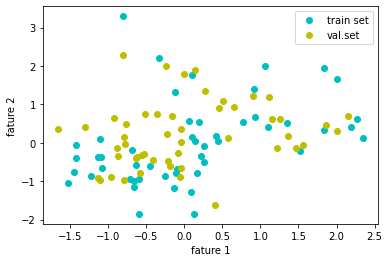

In [97]:
import matplotlib.pyplot as plt
x_val_scaled = (x_val - train_mean) / train_std  # 훈련용 데이터 평균과 표준편차로 표준화해야 함
plt.plot(x_train_scaled[:50,0], x_train_scaled[:50,1], 'co')
plt.plot(x_val_scaled[:50,0], x_val_scaled[:50,1], 'yo')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val.set'])
plt.show()

### 적절한 편향-분산 트레이드오프를 선택한다.

In [ ]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20)  # epochs 20에서 조기종료
layer4.score(x_val_scaled, y_val)

### 교차 검증을 알아보고 사이킷런으로 수행해본다.

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', penalty='l2',alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10)
print(np. mean(scores['test_score']))

### 전처리 단계를 포함해 교차 검증을 수행한다.

In [96]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
pipe = make_pipeline(StandardScaler(),sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True)
print(np.mean(scores['test_score']))

0.9671497584541063
